# Usage E-Journals

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
counter_path = "..." # enter file path

In [4]:
licences_path = "..." # enter file path

## Files


* Script works on the file structure created by the COUNTER 5 Report Tool (https://github.com/CS-4820-Library-Project/COUNTER-5-Report-Tool).
    * exported vendor file for each year
    * COUNTER reports as tsv-files
* File "Zeitschriften_Einzel_Medizin.tsv" lists all individual journal licences and contains the following columns:
    * EMedien_ID
    * Zeitschrift_Name
    * Print_ISSN
    * Online_ISSN
    * Verlag
    * Bestellnummer
    * Abruf_Statistik
    * Jahr
    * Lizenzstart
    * Lizenzende
    * Lizenz_Netto
    * Lizenz_Netto_Waehrung
    * Lizenz_Brutto_Euro
    * Kommentar
* For each year, the file "Zeitschriften_Paket_Medizin_{year}.tsv" lists all jorunal package licences and contains the following columns:
... EMedien_ID	Zeitschrift_ID	Zeitschrift_Name	Print_ISSN	Online_ISSN	Kommentar
* "Paket_Medizin.tsv" ..


## Functions

### Function: Read COUNTER5 reports for a given year and return Unique Item Requests combined in one file

In [ ]:
def read_COUNTER5_UIR(year):
    vendor_data = f"{counter_path}exported_vendor_data_journals_{year}.tsv" #specify vendor file 
    vendors_journals = pd.read_table(vendor_data)["name"].tolist() #make a list of all vendor names
    counter5_journals = [] #create an empty list
    for vendor in vendors_journals: #combine counter5 reports for all vendors into a single list of dataframes, skip first 13 rows of each counter5 report (i.e. the metadata)
        counter5_journals.append(pd.read_table(f"{counter_path}/{year}/{vendor}/{year}_{vendor}_TR_J1.tsv", skiprows=13))
    counter5_journals_df = pd.concat(counter5_journals, axis = 0) #combine all dataframes in the list into one dataframe
    UIR_journals = counter5_journals_df[counter5_journals_df.Metric_Type == "Unique_Item_Requests"] #select only the Unique Item Requests
    UIR_journals = UIR_journals.reset_index(drop=True) #reset row index
    UIR_journals.to_csv(f"{licences_path}/{year}/UIR_journals_{year}.tsv", index=False, sep="\t") #save dataframe as a tsv-file

### Function: Match Counter5 reports to individual journal licences

In [ ]:
def match_individuals(year):
    individuals_data = pd.read_table(f"{licences_path}Zeitschriften_Einzel_Medizin.tsv") #specify journal file
    individuals_data_year = individuals_data[individuals_data.Jahr == year] #select given year
    individuals_data_year = individuals_data_year.reset_index(drop=True) #reset row index
    UIR_journals = pd.read_table(f"{licences_path}/{year}/UIR_journals_{year}.tsv") #specify COUNTER data
    UIR_individuals = pd.merge(left=individuals_data_year, right=UIR_journals, how='left', left_on=['Online_ISSN', 'Print_ISSN'], right_on=['Online_ISSN', 'Print_ISSN']) # left join to match UIR to journals
    return UIR_individuals

### Function: Match Counter5 reports to journal package licences

In [ ]:
def match_packages(year):
    packages_data = pd.read_table(f"{licences_path}Zeitschriften_Paket_Medizin_{year}.tsv") #specify package file
    UIR_journals = pd.read_table(f"{licences_path}/{year}/UIR_journals_{year}.tsv") #specify COUNTER data
    UIR_packages = pd.merge(left=packages_data, right=UIR_journals, how='left', left_on=['Online_ISSN', 'Print_ISSN'], right_on=['Online_ISSN', 'Print_ISSN']) # left join to match UIR to journals in packages
    return UIR_packages                         

### Function: Match files for individual licences and packages for checkig ISSNs

In [ ]:
def check_ISSNs(year):
    UIR_packages = match_packages(year)
    UIR_packages.to_csv(f"{licences_path}/{year}/Zwischenschritte/UIR_packages_{year}.tsv", index=False, sep="\t")
    UIR_individuals = match_individuals(year)
    UIR_individuals.to_csv(f"{licences_path}/{year}/Zwischenschritte/UIR_individuals_{year}.tsv", index=False, sep="\t")

### Function: Match files for individual licences and packages

In [ ]:
def match_ISSNs(year):
    UIR_packages = match_packages(year)
    UIR_packages.to_csv(f"{licences_path}/{year}/UIR_packages_{year}.tsv", index=False, sep="\t")
    UIR_individuals = match_individuals(year)
    UIR_individuals.to_csv(f"{licences_path}/{year}/UIR_individuals_{year}.tsv", index=False, sep="\t")

### Function: Create file for packages usage, summed up for each journal

In [ ]:
def combine_platforms_packages(year):
    UIR_packages = pd.read_table(f"{licences_path}/{year}/UIR_packages_{year}.tsv") #read packages counter data
    packages_info = pd.read_table(f"{licences_path}/Paket_Medizin.tsv") #read packages data
    packages_info_year = packages_info[packages_info.Jahr == year] #select year of interest
    UIR_packages = pd.merge(left=UIR_packages, right=packages_info_year, how="left", on="EMedien_ID") #left join to add publisher data
    UIR_packages = UIR_packages[["EMedien_ID", "Zeitschrift_ID", "Zeitschrift_Name", "Verlag", "Jahr", "Reporting_Period_Total"]]
    UIR_sum_platforms = UIR_packages[["Zeitschrift_ID", "Reporting_Period_Total"]].groupby("Zeitschrift_ID", as_index=False).sum() #Calculate sums for journals accessed on different platforms
    UIR_packages = UIR_packages[["EMedien_ID", "Zeitschrift_ID", "Zeitschrift_Name", "Verlag", "Jahr"]] #select columns of interest, without "Reporting_Period_Total"
    UIR_packages = UIR_packages.drop_duplicates() #remove duplicate rows
    UIR_sum_platforms = pd.merge(left=UIR_sum_platforms, right=UIR_packages, how="left", on="Zeitschrift_ID") #left join to add values from other columns again
    UIR_sum_platforms = UIR_sum_platforms[["EMedien_ID", "Zeitschrift_ID", "Zeitschrift_Name", "Verlag", "Jahr", "Reporting_Period_Total"]] #select columns of interest
    UIR_sum_platforms["Lizenztyp"] = "package"
    return UIR_sum_platforms

### Function: Create file for packages usage, summed up for each package

In [ ]:
def combine_platforms_sum_packages(year):
    UIR_packages = pd.read_table(f"{licences_path}/{year}/UIR_packages_{year}.tsv") #read packages counter data
    packages_info = pd.read_table(f"{licences_path}/Paket_Medizin.tsv") #read packages data
    packages_info_year = packages_info[packages_info.Jahr == year] #select year of interest
    UIR_packages = pd.merge(left=UIR_packages, right=packages_info_year, how="left", on="EMedien_ID") #left join to add publisher data
    UIR_packages = UIR_packages[["EMedien_ID", "Verlag", "Jahr", "Reporting_Period_Total"]]
    UIR_sum_packages = UIR_packages[["EMedien_ID", "Reporting_Period_Total"]].groupby("EMedien_ID", as_index=False).sum() #Calculate sums for packages over journals and different platforms
    UIR_packages = UIR_packages[["EMedien_ID", "Verlag", "Jahr"]] #select columns of interest, without "Reporting_Period_Total"
    UIR_packages = UIR_packages.drop_duplicates() #remove duplicate rows
    UIR_sum_packages = pd.merge(left=UIR_sum_packages, right=UIR_packages, how="left", on="EMedien_ID") #left join to add values from other columns again
    UIR_sum_packages = UIR_sum_packages[["EMedien_ID", "Verlag", "Jahr", "Reporting_Period_Total"]] #select columns of interest
    UIR_sum_packages["Lizenztyp"] = "package"
    return UIR_sum_packages

### Function: Create file for individuals journal usage, summed up for each journal

In [ ]:
def combine_platforms_individuals(year):
    UIR_individuals = pd.read_table(f"{licences_path}/{year}/UIR_individuals_{year}.tsv") #read individuals data
    UIR_individuals["Zeitschrift_ID"] = UIR_individuals["EMedien_ID"].apply(str)  #add column Zeitschrift_ID, value is the same as EMedien_ID
    UIR_individuals = UIR_individuals[["EMedien_ID", "Zeitschrift_ID", "Zeitschrift_Name", "Verlag", "Jahr", "Reporting_Period_Total"]] #select columns of interest
    UIR_sum_platforms = UIR_individuals[["Zeitschrift_ID", "Reporting_Period_Total"]].groupby("Zeitschrift_ID", as_index=False).sum() #Calculate sums for jorunals accessed on different platforms
    UIR_individuals = UIR_individuals[["EMedien_ID", "Zeitschrift_ID", "Zeitschrift_Name", "Verlag", "Jahr"]] #select columns of interest, without "Reporting_Period_Total"
    UIR_individuals = UIR_individuals.drop_duplicates() #remove duplicate rows
    UIR_sum_platforms = pd.merge(left=UIR_sum_platforms, right=UIR_individuals, how="left", on="Zeitschrift_ID") #left join to add values from other columns again
    UIR_sum_platforms = UIR_sum_platforms[["EMedien_ID", "Zeitschrift_ID", "Zeitschrift_Name", "Verlag", "Jahr", "Reporting_Period_Total"]] #select columns of interest
    UIR_sum_platforms["Lizenztyp"] = "individual"
    return UIR_sum_platforms

### Function: Create a bar chart of UIR per journal

In [ ]:
def make_boxplot (UIR_data):
    
    sns.set_theme(style="ticks")
    f, ax = plt.subplots(figsize=(7, 6)) # Initialize the figure
    sns.boxplot(x="Jahr", y="Reporting_Period_Total", data=UIR_data, whis=[0, 100], width=.6, palette="vlag") # Plot UIR with vertical boxes
    sns.stripplot(x="Jahr", y="Reporting_Period_Total", data=UIR_data, color=".3", size=4, linewidth=0) # Add in points to show each observation
    # Adjust the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="Unique Item Requests")
    sns.despine(trim=True, left=True)

In [2]:
def make_log_boxplot (UIR_data):
    
    sns.set_theme(style="ticks")
    f, ax = plt.subplots(figsize=(7, 6)) # Initialize the figure
    ax.set_yscale("log") #logarithmic scale
    sns.boxplot(x="Jahr", y="Reporting_Period_Total", data=UIR_data, whis=[0, 100], width=.6, palette=["w"]) # Plot UIR with vertical boxes
    sns.stripplot(x="Jahr", y="Reporting_Period_Total", data=UIR_data, palette=["grey", "#ad007c"], size=3, linewidth=0, hue="Lizenztyp") # Add in points to show each observation
    # Adjust the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="Unique Item Requests")
    plt.rcParams.update({'font.size': 30})
    sns.despine(trim=True, left=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Lizenztyp") # Place legend to the right of the plot

## Analyses

In [ ]:
years = [2020, 2021, 2022, 2023]

### Read counter reports and match them to licences, write files for checking ISSNs

In [ ]:
for year in years:
    read_COUNTER5_UIR(year) # Read Counter5 Reports and combine into one file
    match_individuals(year) # Match Counter5 reports to individual journal licences
    match_packages(year) # Match Counter5 reports to journal package licences
    check_ISSNs(year) # Match files for individual licences and packages

### ! Manual step: Check wether ISSNs are the same for a given journal in COUNTER reports and files listing journal licences !

### Repeat matching after checking ISSNs

In [ ]:
for year in years:
    match_individuals(year) # Match Counter5 reports to individual journal licences
    match_packages(year) # Match Counter5 reports to journal package licences
    match_ISSNs(year) # Match files for individual licences and packages

### ! Manual step: Add usage data for vendors not offering Counter5 data via SUSHI to lists !

### Create file with UIR for all journals and all years

In [ ]:
UIR_Zeitschrift_IDs = [] #create an empty list
for year in years:
    UIR_Zeitschrift_IDs.append(combine_platforms_individuals(year)) #add UIR of individual journals
    UIR_Zeitschrift_IDs.append(combine_platforms_packages(year)) #add UIR of packages
UIR_Zeitschrift_IDs = pd.concat(UIR_Zeitschrift_IDs, axis = 0) #combine dataframes in the list into one dataframe
UIR_Zeitschrift_IDs.to_csv(f"{licences_path}Gesamtauswertung/UIR_Zeitschriften_IDs.tsv", index=False, sep="\t") #save dataframe as a tsv-file

### Create file with UIR sums for all packages and all years

In [ ]:
UIR_Zeitschrift_IDs_sum_packages = [] #create an empty list
for year in years:
    UIR_Zeitschrift_IDs_sum_packages.append(combine_platforms_sum_packages(year)) #add UIR of individual journals
UIR_Zeitschrift_IDs_sum_packages = pd.concat(UIR_Zeitschrift_IDs_sum_packages, axis = 0)
UIR_Zeitschrift_IDs_sum_packages.to_csv(f"{licences_path}Gesamtauswertung/UIR_Zeitschriften_IDs_sum_packages.tsv", index=False, sep="\t") #save dataframe as a tsv-file

### Create a file without journals with no UIR

In [5]:
UIR_Zeitschrift_IDs = pd.read_table(f"{licences_path}Gesamtauswertung/UIR_Zeitschriften_IDs_Grafik.tsv") #read data
UIR_Zeitschrift_IDs_noZeros = UIR_Zeitschrift_IDs[UIR_Zeitschrift_IDs["Reporting_Period_Total"] != 0]

## Graphical representation

### Boxplot looking at UIR for all journals per year

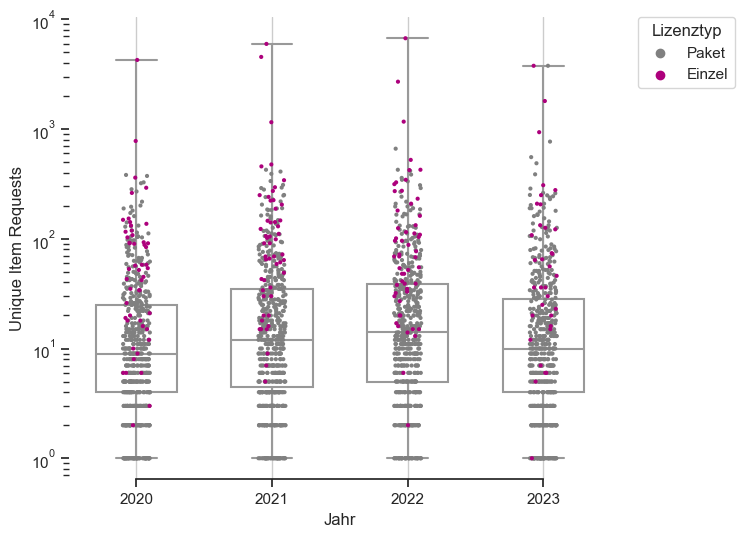

In [6]:
make_log_boxplot(UIR_Zeitschrift_IDs_noZeros)
plt.savefig(f"{licences_path}/Gesamtauswertung/Boxplot_UIR_Journals.svg", dpi=100, bbox_inches='tight', format="svg")

### Show statistics

In [7]:
UIR_Zeitschrift_IDs_noZeros.groupby("Jahr").describe()

Reporting_Period_Total                                               \
                      count       mean         std  min  25%   50%   75%   
Jahr                                                                       
2020                  597.0  34.770519  182.966603  1.0  4.0   9.0  25.0   
2021                  611.0  55.000000  311.551417  1.0  4.5  12.0  35.0   
2022                  587.0  58.093697  309.307875  1.0  5.0  14.0  39.0   
2023                  569.0  49.558875  245.719418  1.0  4.0  10.0  28.0   

              
         max  
Jahr          
2020  4266.0  
2021  5974.0  
2022  6727.0  
2023  3775.0